In [1]:
# Data Manipulation Modules
import pandas as pd
import numpy as np
import scipy as sp
import numpy as np
import math 
import scipy.stats as stats
from collections import Counter

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as ms

# Managing Warnings 
import warnings
warnings.filterwarnings('ignore')

In [2]:
Final = pd.read_pickle("../data/Final.pkl")

# Results!

In [3]:
Stats = Final[['Season', 'Receiver', 'Nearest_Defender', 'Separation', 'Pred_Sep', 'TD', 'Pass Yds', 'INT', 'Cmp', 'Team', 'Air_Yds']]
Stats['Sep_Diff'] = Stats['Separation'] - Stats['Pred_Sep']

In [4]:
COUNT_df = Stats.groupby(['Receiver', 'Season']).nunique()
COUNT_df = COUNT_df.rename(columns = {'Separation':'Targets'})
COUNT_df = COUNT_df[['Targets']]
Final_df = Stats.merge(COUNT_df, on = ['Receiver', 'Season'])

### Year over Year stability of Separation Differential

Below is a table showing how correlated a receivers average Separation Differential is year-over-year. Turns out, among receievers with at least 70 targets in each of the last 3 years, there is a low, but non-zero correlation between those figures over three seasons. Considering the variable nature of separation, this is to be expected, but I would be worth looking into why these correlation values aren't more stable year over year.

In [5]:
YoY = Final_df[Final_df['Targets'] >= 70]
YoY = YoY.groupby(['Receiver', 'Season'])[['Separation', 'Pred_Sep', 'Sep_Diff']].mean()
YoY = pd.pivot_table(YoY, values='Sep_Diff',index='Receiver', columns=['Season']).corr().round(3)
YoY

Season,2017,2018,2019
Season,,,
2017,1.000,0.314,0.250
2018,0.314,1.000,0.379
2019,0.250,0.379,1.000


### How do the players stack up?

In [6]:
Season = Final_df[['Receiver', 'Separation', 'Pred_Sep', 'Sep_Diff', 'Season', 'Targets']]
Season = Season.groupby(['Receiver', 'Season']).mean().reset_index().round(2)

In [7]:
#Create df since 2017

Since17 = Stats[['Receiver', 'Separation', 'Pred_Sep', 'Sep_Diff']]
Since17_df = Since17.groupby(['Receiver']).mean().reset_index().round(2)
COUNT = Stats.groupby(['Receiver']).nunique()
COUNT = COUNT.rename(columns = {'Separation':'Targets'})
COUNT_1 = COUNT[['Targets']]
Since17_df = Since17_df.merge(COUNT_1, on = ['Receiver'])

## Top 10 Highest Average Separation Above Expectation since 2017

In [8]:
Career = Since17_df[Since17_df['Targets'] > 150].sort_values(['Sep_Diff'], ascending = False)
Career.head(10)

,Receiver,Separation,Pred_Sep,Sep_Diff,Targets
584,Sammy Watkins,2.96,2.55,0.41,253
117,Chris Hogan,3.09,2.68,0.41,154
10,Albert Wilson,3.73,3.38,0.35,159
679,Will Fuller,2.95,2.61,0.34,174
666,Tyreek Hill,3.26,2.93,0.33,373
623,Ted Ginn,3.02,2.73,0.29,188
94,Calvin Ridley,3.02,2.73,0.29,184
410,Kendrick Bourne,2.75,2.48,0.27,153
195,DeSean Jackson,2.77,2.50,0.27,172
25,Amari Cooper,2.76,2.52,0.24,336


## Top 10 Lowest Average Separation Above Expectation

In [9]:
Career.sort_values(['Sep_Diff'], ascending = True).head(10)

,Receiver,Separation,Pred_Sep,Sep_Diff,Targets
264,Golden Tate,2.66,3.07,-0.40,324
429,Larry Fitzgerald,2.60,2.98,-0.38,378
98,Cameron Brate,2.61,2.96,-0.35,175
561,Rob Gronkowski,2.39,2.70,-0.31,209
21,Allen Robinson,2.14,2.43,-0.28,260
187,David Njoku,2.74,3.01,-0.27,157
349,Jimmy Graham,3.00,3.24,-0.24,249
413,Kenny Golladay,2.12,2.34,-0.22,273
199,Delanie Walker,2.83,3.03,-0.21,162
499,Mike Williams,1.95,2.12,-0.17,194


## 2019 Only

In [10]:
df_2019 = Season[(Season['Targets'] > 75) & (Season['Season'] == 2019)].sort_values(['Sep_Diff'], ascending = False).reset_index(drop = True)
df_2019.head(10)

,Receiver,Season,Separation,Pred_Sep,Sep_Diff,Targets
0,Diontae Johnson,2019,3.62,3.14,0.48,92
1,Davante Adams,2019,3.31,2.90,0.41,149
2,Will Fuller,2019,2.89,2.55,0.34,79
3,Sammy Watkins,2019,3.03,2.72,0.32,108
4,Sterling Shepard,2019,3.13,2.82,0.31,83
5,Tyreek Hill,2019,3.23,2.92,0.31,114
6,Travis Kelce,2019,3.02,2.75,0.28,157
7,Christian Kirk,2019,3.48,3.20,0.28,106
8,Cole Beasley,2019,3.25,2.97,0.28,111
9,Austin Hooper,2019,3.39,3.13,0.27,96


In [11]:
df_2019.sort_values(['Sep_Diff'], ascending = True).head(10)

,Receiver,Season,Separation,Pred_Sep,Sep_Diff,Targets
66,Golden Tate,2019,2.17,2.71,-0.54,85
65,Marvin Jones,2019,2.09,2.53,-0.44,91
64,Larry Fitzgerald,2019,2.98,3.34,-0.36,109
63,Kenny Golladay,2019,1.95,2.25,-0.30,113
62,Julio Jones,2019,2.16,2.46,-0.29,156
61,Dallas Goedert,2019,3.10,3.36,-0.27,92
60,Jamison Crowder,2019,3.01,3.26,-0.26,121
59,Terry McLaurin,2019,2.10,2.31,-0.21,92
58,Mike Gesicki,2019,2.62,2.83,-0.21,89
57,Jarvis Landry,2019,2.59,2.78,-0.19,134


In [12]:
df_2019.sort_values(['Separation'], ascending = True).head(10)

,Receiver,Season,Separation,Pred_Sep,Sep_Diff,Targets
63,Kenny Golladay,2019,1.95,2.25,-0.30,113
46,Mike Williams,2019,2.00,2.09,-0.09,90
54,DeVante Parker,2019,2.03,2.20,-0.18,126
65,Marvin Jones,2019,2.09,2.53,-0.44,91
59,Terry McLaurin,2019,2.10,2.31,-0.21,92
62,Julio Jones,2019,2.16,2.46,-0.29,156
41,Darius Slayton,2019,2.16,2.22,-0.06,84
66,Golden Tate,2019,2.17,2.71,-0.54,85
50,Robby Anderson,2019,2.19,2.29,-0.10,95
51,Michael Gallup,2019,2.22,2.37,-0.15,113


In [13]:
df_2019.sort_values(['Pred_Sep'], ascending = False).head(10)

,Receiver,Season,Separation,Pred_Sep,Sep_Diff,Targets
11,Tyler Higbee,2019,3.70,3.46,0.23,88
45,George Kittle,2019,3.29,3.37,-0.08,115
61,Dallas Goedert,2019,3.10,3.36,-0.27,92
64,Larry Fitzgerald,2019,2.98,3.34,-0.36,109
37,Robert Woods,2019,3.33,3.34,-0.01,138
53,Darren Waller,2019,3.14,3.30,-0.16,117
60,Jamison Crowder,2019,3.01,3.26,-0.26,121
36,Dede Westbrook,2019,3.20,3.20,-0.01,101
7,Christian Kirk,2019,3.48,3.20,0.28,106
10,Cooper Kupp,2019,3.39,3.14,0.25,134


# Exceptional Separation Rate

For me, these numbers are a little underwhelming. No one is going to jump out of their seat to hear 'Davante Adams exceeds his predicted separation by .4 yards per target!' Well, I will, but let's see if we can't create something more digestable. Below I will create a stat called 'Exceptional Separation Rate' that tallies all the instances where a receiver exceeds their predicted separation, and divide that by their total targets to see how often they are exceeding expectations. 

In [14]:
Final_ES = Stats.copy()
Final_ES['ES'] = 0
Final_ES['ES'].loc[Final_ES['Sep_Diff']> 0] = 1
Final_ES = Final_ES.merge(COUNT_1, on = ['Receiver'])
Final_ES = Final_ES[['Receiver', 'ES', 'Targets', 'Sep_Diff']]
Final_ES = Final_ES.groupby(['Receiver']).mean().round(2)
Final_ES = Final_ES.sort_values(['ES'], ascending = False)
Final_ES = Final_ES[Final_ES['Targets'] >= 160]
Final_ES.head(10)

,ES,Targets,Sep_Diff
Receiver,,,
Will Fuller,0.51,174.0,0.34
Tyreek Hill,0.51,373.0,0.33
Ted Ginn,0.51,188.0,0.29
Calvin Ridley,0.51,184.0,0.29
Davante Adams,0.50,432.0,0.24
Cooper Kupp,0.50,296.0,0.19
DeSean Jackson,0.49,172.0,0.27
Julian Edelman,0.48,297.0,0.11
Sammy Watkins,0.48,253.0,0.41


In [15]:
Final_ES.sort_values(['ES'], ascending = True).head(10)

,ES,Targets,Sep_Diff
Receiver,,,
Kenny Golladay,0.30,273.0,-0.22
Larry Fitzgerald,0.31,378.0,-0.38
Rob Gronkowski,0.33,209.0,-0.31
Devin Funchess,0.33,201.0,-0.08
Cameron Brate,0.33,175.0,-0.35
Golden Tate,0.33,324.0,-0.40
Jimmy Graham,0.34,249.0,-0.24
Mike Williams,0.34,194.0,-0.17
Allen Robinson,0.34,260.0,-0.28


## Why should you care?

I **don't** want your takeaway here to see the above lists and think 'Kenny Golladay is Bad' or 'Sammy Watkins is amazing.'

The goal of this exercise is try and extract information from recevier separation, and the analysis doesn't end with these numbers. In an attmept to see how this stat looks on the team scale, I correlated *win percentage* over the last three seasons with the teams *average team separation differential* to see how this stat did to predict team success. 

In [16]:
WinPct = [.813, .750, .438, .563, .625, .438, .625, .375, .313, .875, .438, .750, 
          .688, .344, .500, .375, .500, .625, .438, .563, .438, .563, .500, .313, 
          .813, .438, .188, .125, .813, .250, .313, .219]

WP_AS = [.704, .551, .510, .490, .746, .451, .500, .560, .375, .673, .625, .354, 
         .660, .608, .440, .648, .277, .736, .540, .375, .566, .354, .647, .469, 
         .333, .500, .312, .354, .250, .510, .340, .383]

Teams = ['KC','GB','HOU','SF','NE','JAX','ATL','DAL','DEN','LA','PIT','TB','BAL',
         'SEA','IND','PHI','CLE','NO','LAC','MIA','TEN','OAK','MIN','CAR','NYJ',
         'BUF','CIN','WAS','NYG','CHI','ARI','DET']


d = {'Team': Teams, 'Win Pct': WP_AS}
Three_Year = pd.DataFrame(d)

In [17]:
Teams = Stats[['Separation', 'Pred_Sep','Team']]
Teams['Sep_Diff'] = Teams['Separation'] - Teams['Pred_Sep']
Team_df = Teams.groupby(['Team']).mean().sort_values(['Sep_Diff'], ascending = False)
Combined = Team_df.merge(Three_Year, on = 'Team')
Combined.round(3).head(32)

,Team,Separation,Pred_Sep,Sep_Diff,Win Pct
0,KC,3.281,2.979,0.302,0.704
1,GB,3.200,3.078,0.122,0.551
2,SF,2.991,2.904,0.087,0.490
3,HOU,2.902,2.822,0.079,0.510
4,SEA,2.930,2.864,0.066,0.608
5,NE,2.879,2.820,0.058,0.746
6,ATL,2.954,2.899,0.055,0.500
7,JAX,2.974,2.922,0.052,0.451
8,LA,3.142,3.094,0.048,0.673
9,IND,3.011,2.967,0.044,0.440


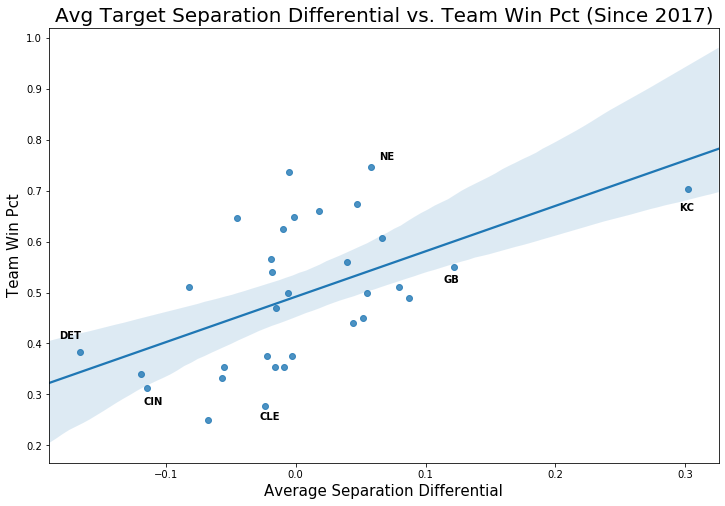

In [30]:
fig, ax = plt.subplots(figsize = (12,8))

fig = sns.regplot(x= 'Sep_Diff', y = 'Win Pct', data = Combined)

ax.set_title('Avg Target Separation Differential vs. Team Win Pct (Since 2017)', fontsize = 20)
ax.set_ylabel('Team Win Pct', fontsize = 15)
fig.text(.295, .66, "KC", horizontalalignment='left', size='medium', color='black', weight='semibold')
fig.text(-.165, .41, "DET", horizontalalignment='right', size='medium', color='black', weight='semibold')
fig.text(.12, .52, "GB", horizontalalignment='center', size='medium', color='black', weight='semibold')
fig.text(-.02, .25, "CLE", horizontalalignment='center', size='medium', color='black', weight='semibold')
fig.text(.07, .76, "NE", horizontalalignment='center', size='medium', color='black', weight='semibold')
fig.text(-.11, .28, "CIN", horizontalalignment='center', size='medium', color='black', weight='semibold')
A = ax.set_xlabel('Average Separation Differential', fontsize = 15)

Amazingly enough, teams with higher average separation differentials **won more often** than teams with lower separation differentials.

In [19]:
print('Correlation value of Team Winning Pct and Separation Differential: ' + str(Combined['Win Pct'].corr(Combined['Sep_Diff'], method = 'spearman').round(2)))

Correlation value of Team Winning Pct and Separation Differential: 0.57


I know what you are thinking, "*of course it is! receiver separation is a good thing, so teams with higher separation win more!*"

Yes, that is true, BUT, separation differential is actually a **better predictor of team success** than average separation. 

In [20]:
print('Correlation value of Team Winning Pct and Separation Differential: ' + str(Combined['Win Pct'].corr(Combined['Separation'], method = 'spearman').round(2)))

Correlation value of Team Winning Pct and Separation Differential: 0.48


## Potential Improvements

If I had more time/resources/data, what would I do to make these predictions better?
   1. Spend more time with hyperparameter tuning
      - In the Light Gradient Boosted Model, I stand to gain a lot with more understanding/experience of how the hyperparameters affect the predictions.
   2. Add new features to model
      - I think absolute yardline (where the play starts from on the field) would be helpful to creating predictions

## Thanks for reading!

Thank you all for reading. If you have any questions, suggestions, or any feedback at all, feel free to reach out at JesseDCohen@gmail.com. 